In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import time
import pandas as pd
import argparse

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from numpy import linalg as LA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from fashion_model import FashionCNN 
from manifold_torch import Manifold_Image_Sampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# prog_args = arg_parse()

EXPERIMENT = 'fashion_mnist'
RADIUS = 0.00001
NUM_PERTURBATIONS = 100
MULTIPLIER = 100
DIM = 3
PIVOTS = 10
SHUFFLE = False
TARGET = None

print("EXPERIMENT: ", EXPERIMENT)
print("RADIUS: ", RADIUS)
print("TARGET: ", TARGET)
print("DIM: ", DIM)
print("PIVOTS: ", PIVOTS)
print("SHUFFLE: ", SHUFFLE)

Matplotlib is building the font cache; this may take a moment.


EXPERIMENT:  fashion_mnist
RADIUS:  1e-05
TARGET:  None
DIM:  3
PIVOTS:  10
SHUFFLE:  False


In [2]:
if EXPERIMENT == 'fashion_mnist':
    print("Loading fashion mnist")
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
elif EXPERIMENT == 'mnist':
    print("Loading mnist")
    train_set = torchvision.datasets.MNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
else:
    print("Nothing to do.")
    
print("Done loading")
    
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))


Loading fashion mnist
Done loading


In [3]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))

start_time = time.time()
manifold_sampler = Manifold_Image_Sampler(all_images, dim = DIM, labels = all_labels)
duration = time.time() - start_time
print("Initialize duration: ", duration)

if TARGET == None:
    targets = None
    target_str = 'all'
else:
    targets = [TARGET]
    target_str = str(TARGET)

# Get the hyperplanes
_ = manifold_sampler.get_pivots(manifold_sampler.labels, MULTIPLIER, shuffle = SHUFFLE, target_labels=targets)
manifold_G = manifold_sampler.get_G_from_pivots()
Gu, Gd, Gv = np.linalg.svd(manifold_G, full_matrices=False)

Initialize duration:  66.0824224948883


In [4]:
# manifold_sampler.get_G_from_samples(manifold_sampler.pivots[0:MULTIPLIER])

In [4]:
checkpt_file = 'pretrained/fashionCNN.pt'
print(checkpt_file)

model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load(checkpt_file))

pretrained/fashionCNN.pt


<All keys matched successfully>

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 

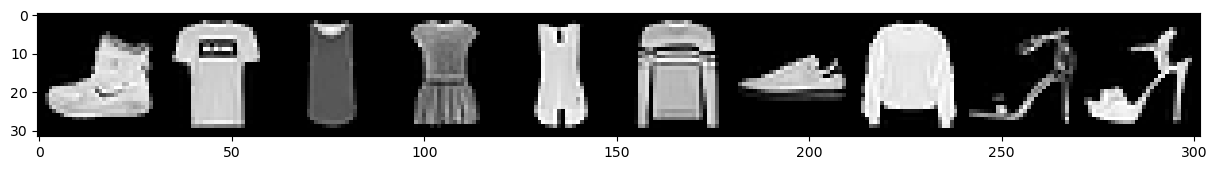

In [5]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(label.item(), end=", ")

In [6]:
# manifold_sampler.pivots.shape

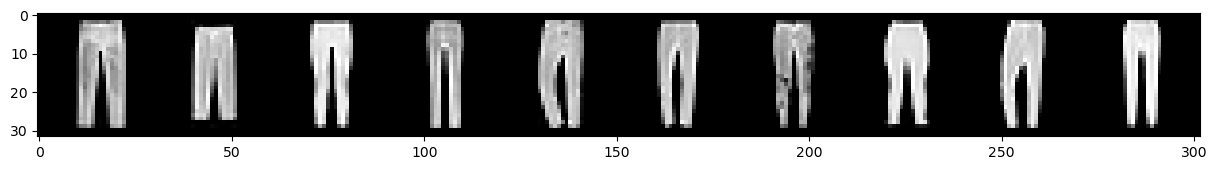

In [7]:
grid = torchvision.utils.make_grid(manifold_sampler.pivots[100:110], nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [8]:
from sklearn import linear_model

# n_samples = 100
sigma = 10
sim_sigma = 4

def similarity_kernel(v1,v2,kernel_width = 1):
    l2_dist = np.linalg.norm(v1 - v2)
    return np.exp(- (l2_dist**2) / (kernel_width**2))

def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

In [9]:
# DUPLICATIONS = 10
# RADIUS = 0.00001
# base_RADIUS = 0.00001
# base_images = []
# perturbations = []
# gauss_perturb = []

# for _ in range(DUPLICATIONS):
#     # base
#     base_gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
#     r = np.random.uniform()*base_RADIUS
#     base_gauss_norm = normalize(base_gauss_, r)
#     base_pc = manifold_sampler.to_1d(manifold_sampler.pivots + base_gauss_norm)
    
#     # gauss
#     gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
#     gauss_noise = manifold_sampler.to_1d(gauss_)
#     plane_noise = np.zeros_like(gauss_noise)
#     for d in range(Gv.shape[0]):
#         proj = np.dot(gauss_noise, Gv[d])
#         for s in range(plane_noise.shape[0]):
#             plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
#     ortho_noise = gauss_noise - plane_noise
    
#     # noise
#     r = np.random.uniform()*RADIUS
#     ortho_norm = normalize(ortho_noise, r)
#     ortho_pc = base_pc + ortho_norm
    
#     perturbations.append(manifold_sampler.to_3d(ortho_pc))
    
# perturbations = torch.cat(perturbations)    
# perturb_embeded = manifold_sampler.transform(perturbations)

In [10]:
DUPLICATIONS = 10
RADIUS = 0.00001
base_RADIUS = 0.00001
base_images = []
perturbations = []
gauss_perturb = []

for _ in range(DUPLICATIONS):
    # base
    base_gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
    r = np.random.uniform()*base_RADIUS
    base_gauss_norm = normalize(base_gauss_, r)
    base_pc = manifold_sampler.to_1d(manifold_sampler.pivots + base_gauss_norm)
    
    # gauss
    gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
    gauss_noise = manifold_sampler.to_1d(gauss_)
    plane_noise = np.zeros_like(gauss_noise)
    for d in range(Gv.shape[0]):
        proj = np.dot(gauss_noise, Gv[d])
        for s in range(plane_noise.shape[0]):
            plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
    ortho_noise = gauss_noise - plane_noise
    
    # noise
    r = np.random.uniform()*RADIUS
    ortho_norm = normalize(ortho_noise, r)
    gauss_norm = normalize(gauss_noise, r)
    ortho_pc = base_pc + ortho_norm
    gauss_pc = base_pc + gauss_norm
    base_images.append(manifold_sampler.to_3d(base_pc))
    perturbations.append(manifold_sampler.to_3d(ortho_pc))
    gauss_perturb.append(manifold_sampler.to_3d(gauss_pc))
    
base_images   = torch.cat(base_images)
perturbations = torch.cat(perturbations)
gauss_perturb = torch.cat(gauss_perturb)
base_embeded    = manifold_sampler.transform(base_images)
perturb_embeded = manifold_sampler.transform(perturbations)
gauss_embeded   = manifold_sampler.transform(gauss_perturb)

In [11]:
no_samples, channels, rows, cols = all_images.shape

In [12]:
index_to_explain = 1
image_to_explain = manifold_sampler.pivots[index_to_explain]

perturb_outputs = model(perturbations.float().to(device))
probs = nn.functional.softmax(perturb_outputs, dim = 1)

original_output = model(image_to_explain.unsqueeze(0).to(device))
first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
perturb_1st = probs[:,first_prediction.item()].cpu().detach().numpy()
perturb_2nd = probs[:,second_prediction.item()].cpu().detach().numpy()

In [13]:
base_embeded = manifold_sampler.transform(image_to_explain.unsqueeze(0))
similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = 1) for i in range(perturbations.shape[0])]

In [14]:
repeat_shape = (perturbations.shape[0],) + tuple(np.ones(image_to_explain.ndim). astype(int))
repeat_image_to_explain = image_to_explain.repeat(repeat_shape)
true_perturb = perturbations - repeat_image_to_explain

In [15]:
from skimage.segmentation import slic, quickshift
from skimage.segmentation import mark_boundaries
import random

def shap_score(model, torch_img, torch_bg, runs = 1, n_segments = 100, compactness = 0.0001):
    np_bg = torch_img_to_np(torch_bg.unsqueeze(0))
    np_im, np_3D_im, segments_slic = segment_img(torch_img.unsqueeze(0), n_segments=n_segments, compactness=compactness, sigma=0.1, start_label=0)
    
    original_output = model(torch_img.unsqueeze(0).to(device))
    ori_probs = nn.functional.softmax(original_output, dim = 1)
    first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
    ori_probs_value = ori_probs[:,first_prediction.item()].cpu().detach().numpy()
    
    perturbation_output = model(torch_bg.unsqueeze(0).float().to(device))
    perturb_probs = nn.functional.softmax(perturbation_output, dim = 1)
    perturb_init_value = perturb_probs[:,first_prediction.item()].cpu().detach().numpy()

    score = np.zeros_like(segments_slic).astype(np.float32)
    segment_idx = list(np.unique(segments_slic))
    old_value = perturb_init_value
    
    np_shap_perturb = np_bg.copy()
    for r in range(runs):
        random.shuffle(segment_idx)
        np_shap_perturb = np_bg.copy()
        for feature_value in segment_idx:
            np_shap_perturb[segments_slic == feature_value] = np_im[segments_slic == feature_value]
            torch_shap_perturb = np_to_torch_img(np_shap_perturb)
            torch_shap_pred = model(torch_shap_perturb.to(device))
            shap_probs = nn.functional.softmax(torch_shap_pred, dim = 1)
            torch_shap_pred_value = shap_probs[:,first_prediction.item()].cpu().detach().numpy()
            inc_score = torch_shap_pred_value - old_value
            old_value = torch_shap_pred_value
            score[segments_slic == feature_value] =+ inc_score[0]
    return score/runs


def torch_img_to_np(torch_img):
    np_img = torch_img.numpy()
    np_img = np.swapaxes(np_img,0,1)
    np_img = np.swapaxes(np_img,1,2)
    np_img = np.swapaxes(np_img,2,3)
    return np_img[0]

def np_to_torch_img(np_img):
    np_img = np.swapaxes(np_img,2,1)
    np_img = np.swapaxes(np_img,1,0)
    torch_img = torch.Tensor(np_img)
    return torch_img.unsqueeze(0)

def segment_img(torch_img, n_segments=10, compactness=2, sigma=1, start_label=0):
    np_img = torch_img_to_np(torch_img)
    segments_slic = slic(np_img, n_segments=n_segments, compactness=compactness,
                         sigma=sigma, start_label=start_label)
    return np_img, np.repeat(np_img, 3, axis=2), segments_slic

def binarize_np(np_array, number_of_ones):
    rows, cols = np_array.shape
    binarize_np = np.zeros_like(np_array.reshape(rows*cols))
    top_indices = np.argpartition(np_array.reshape(rows*cols), -number_of_ones)[-number_of_ones:]
    binarize_np[top_indices]  = 1

    return binarize_np.reshape(1,1,rows,cols)

(-0.5, 27.5, 27.5, -0.5)

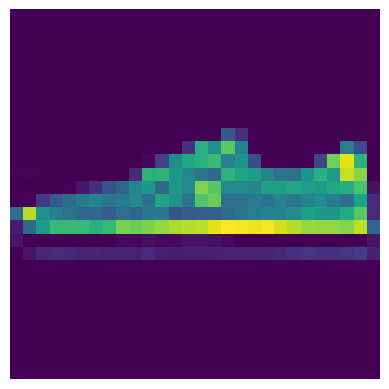

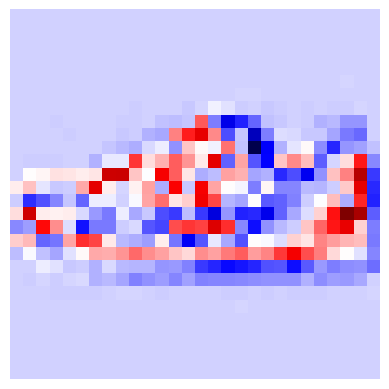

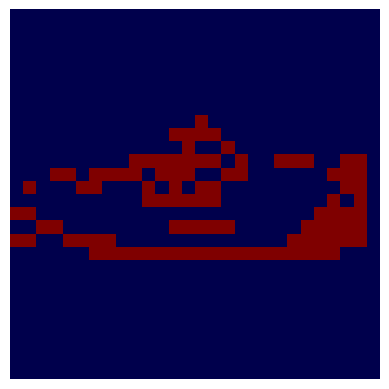

In [193]:
index_to_explain = 701
image_to_explain = manifold_sampler.pivots[index_to_explain]

perturb_outputs = model(perturbations.float().to(device))
probs = nn.functional.softmax(perturb_outputs, dim = 1)

original_output = model(image_to_explain.unsqueeze(0).to(device))
first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
perturb_1st = probs[:,first_prediction.item()].cpu().detach().numpy()
perturb_2nd = probs[:,second_prediction.item()].cpu().detach().numpy()

base_embeded = manifold_sampler.transform(image_to_explain.unsqueeze(0))
similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = 1) for i in range(perturbations.shape[0])]

repeat_shape = (perturbations.shape[0],) + tuple(np.ones(image_to_explain.ndim). astype(int))
repeat_image_to_explain = image_to_explain.repeat(repeat_shape)
true_perturb = perturbations - repeat_image_to_explain

clf = linear_model.Ridge(alpha = 200)
clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_1st, sample_weight=similarities)
# explanation_1st = np.abs(clf.coef_.reshape(rows, cols))
explanation_1st = -clf.coef_.reshape(rows, cols)

# clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_2nd, sample_weight=similarities)
# explanation_2nd = -clf.coef_.reshape(rows, cols)

plt.imshow(image_to_explain[0])
plt.axis('off')

plt.figure()
plt.imshow(explanation_1st, cmap=plt.get_cmap('seismic'))
plt.axis('off')

# plt.figure()
# plt.imshow(explanation_2nd, cmap=plt.get_cmap('seismic'))

plt.figure()
plt.imshow(binarize_np(explanation_1st, 100)[0,0], cmap=plt.get_cmap('seismic'))
plt.axis('off')

tensor([[-2.8734, -1.3220, -3.9417, -4.2628, -4.3987,  5.4697, -4.8983, 10.7405,
         -0.5063,  5.4887]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.3444, -1.4050, -4.2539, -5.5466, -5.2930,  7.6694, -7.1232, 13.7582,
         -0.5290,  6.4767]], device='cuda:0', grad_fn=<AddmmBackward>)


(-0.5, 27.5, 27.5, -0.5)

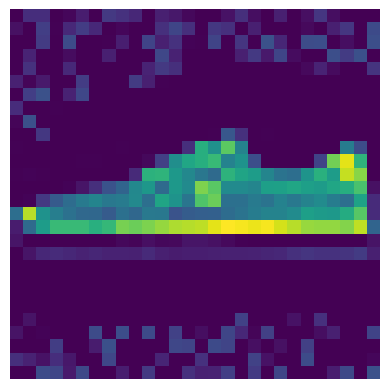

In [186]:
no_ones = 500
p_act = 0.5

mask = torch.Tensor(binarize_np(explanation_1st, no_ones)[0,0])
inp = image_to_explain[0]
perturb = torch.clip(inp + (1 - mask) * (torch.rand_like(inp)-0.5)*p_act,0,1)

model.eval()
print(model(perturb.reshape(1,1,28,28).to(device)))
print(model(inp.reshape(1,1,28,28).to(device)))

plt.figure()
plt.imshow(perturb.detach().numpy())
plt.axis('off')

In [179]:
model.eval()
print(model(perturb.reshape(1,1,28,28).to(device)))
print(model(inp.float().reshape(1,1,28,28).to(device)))


tensor([[-2.2601, -1.4858, -1.5631, -1.9812, -2.2116,  2.8905, -2.3970,  4.4566,
          2.2606, -0.1769]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.3444, -1.4050, -4.2539, -5.5466, -5.2930,  7.6694, -7.1232, 13.7582,
         -0.5290,  6.4767]], device='cuda:0', grad_fn=<AddmmBackward>)


In [174]:
inp = inp.float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


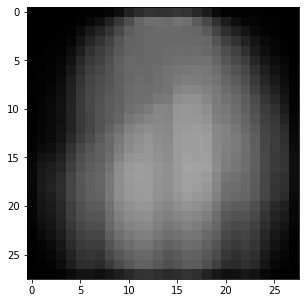

In [17]:
view_label = 1

shap_bg = torch.mean(base_images, dim = 0)

grid = torchvision.utils.make_grid(shap_bg, nrow=10)
plt.figure(figsize=(5, 5))
plt.imshow(np.transpose(grid, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


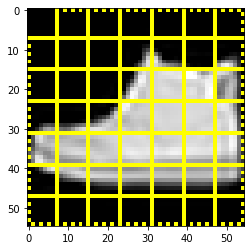

In [105]:
np_bg = torch_img_to_np(shap_bg.unsqueeze(0))
np_im, np_3D_im, segments_slic = segment_img(image_to_explain.unsqueeze(0), n_segments=50, compactness=100, sigma=1, start_label=0)

plt.imshow(mark_boundaries(np_3D_im, segments_slic, mode = 'subpixel'))

(-0.5, 27.5, 27.5, -0.5)

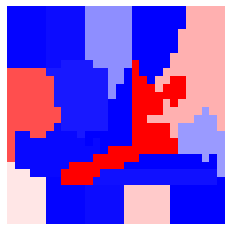

In [111]:
score = -shap_score(model, image_to_explain, shap_bg, runs = 100, n_segments = 32, compactness = 0.001)
plt.imshow(np.abs(score),cmap=plt.get_cmap('bwr'))
plt.axis('off')

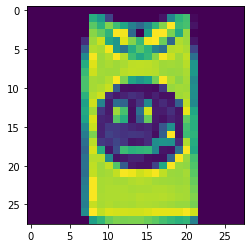

In [24]:
plt.imshow(image_to_explain[0])

In [ ]:
explanation_diff = explanation_1st - explanation_2nd

plt.figure()
plt.imshow(explanation_diff, cmap=plt.get_cmap('seismic'))

In [179]:
def gen_mask(score, ones_ratio = 0.2):
    no_rows, no_cols = score.shape
    score_flat = np.reshape(score, no_rows*no_cols)
    top_k = int(ones_ratio*no_rows*no_cols)
    idx = np.argpartition(score_flat, -top_k)[-top_k:]
    indices = idx[np.argsort((-score_flat)[idx])]
    score_flat_dup = np.zeros_like(score_flat)
    score_flat_dup[indices] = 1.0
    score_dup = score_flat_dup.reshape(no_rows, no_cols)
    return score_dup

In [180]:
def compute_log_odds(img, score, ones_ratio):
    diff_mask = gen_mask(score, ones_ratio)
    mod_img = img.clone().numpy()
    mod_img[0][diff_mask==1] = 0.0
    mod_img = torch.tensor(mod_img)
    
    

In [181]:
modified_image = image_to_explain.clone().numpy()
modified_image[0][s_diff_mask==1] = 0.0
modified_image = torch.tensor(modified_image)

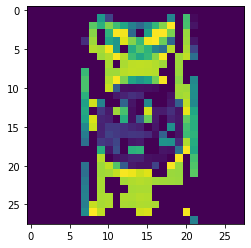

In [182]:
plt.figure()
plt.imshow(modified_image[0])

In [183]:
modified_output = model(modified_image.unsqueeze(0).to(device))
m_first_prediction, m_second_prediction = torch.topk(modified_output, 2)[1][0]

In [184]:
original_output - modified_output

tensor([[ 6.5721, -4.0996,  4.8324, -3.5758,  0.5814, -2.0957,  2.1837, -2.2061,
          2.3000, -4.5867]], device='cuda:0', grad_fn=<SubBackward0>)

In [185]:
first_prediction

tensor(0, device='cuda:0')

In [186]:
torch.topk(original_output, 2)[1][0]

tensor([0, 6], device='cuda:0')

In [187]:
original_output

tensor([[ 8.8735, -3.6232,  0.3718, -0.2533, -1.3968,  0.9781,  1.7420, -5.2031,
          1.7346, -6.1235]], device='cuda:0', grad_fn=<AddmmBackward>)

In [188]:
modified_output

tensor([[ 2.3014,  0.4763, -4.4606,  3.3226, -1.9782,  3.0738, -0.4417, -2.9970,
         -0.5654, -1.5368]], device='cuda:0', grad_fn=<AddmmBackward>)